In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from spiking_radio_reservoir import setup_connectivity

In [2]:
N=200
pInh=0.2
pIR=0.3
Ngx=5
Ngy=5
Ngz=8
AoC=[0.3, 0.5, 0.1]
DoC=2
loc_wRes=1050
scale_wRes=105

In [3]:
connectivity = setup_connectivity(N, pInh, pIR, Ngx, Ngy, Ngz, AoC, DoC, loc_wRes, scale_wRes)

# Graph

Represent the connections between the neurons of the reservoir as directed graph. The graph is defined by an adjancency matrix extracted from the _source_ and _target_ neurons information stored in the connectivity object.

In [ ]:
A = np.zeros((N, N))
for n in range(N):
    idx = np.where(connectivity['res_res']['i']==n)[0]
    m = connectivity['res_res']['j'][idx]
    A[n, m] = 1

In [ ]:
plt.figure()
plt.imshow(A.T, interpolation='nearest', origin='low', aspect='auto', \
                extent=[0, N, 0, N], cmap='viridis', vmin=0, vmax=1)

In [6]:
types = list(map(lambda x: x[1], connectivity['grid'].reshape((N, -1))))

In [7]:
G = nx.DiGraph()
G.add_nodes_from(np.arange(N), type=types)

In [8]:
edges = list(zip(connectivity['res_res']['i'], connectivity['res_res']['j'], connectivity['res_res']['w']))

In [9]:
G.add_weighted_edges_from(edges)

In [10]:
pos = nx.circular_layout(G)
edgewidth = [d['weight'] for (u,v,d) in G.edges(data=True)]

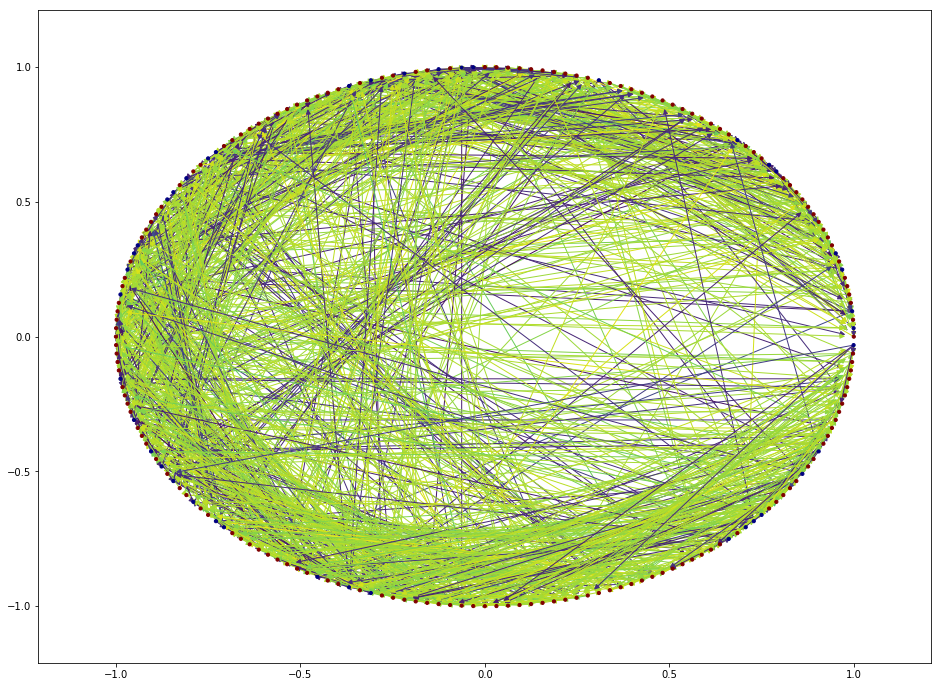

In [11]:
plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(G, pos, node_size=10, node_color=types, cmap=plt.get_cmap('jet'), vmin=-1.0, wma=1.0)
nx.draw_networkx_edges(G, pos, edge_color=edgewidth)
plt.show()

### Degree

The degree of a node in a graph is the number of adjecent edges. In the case of a directed graph we distringuish between the set of incoming edges and outgoing edges. For every node we can thus compute the in- and out-degree by summing over the set of incoming and outgoing edges of the node. Further, when the edges have been labeled with a weight the sum is replaced with a weighted sum. A graph is called balanced if the in-degree and out-degree is equal for every node.

In [25]:
indegree = [val for (node, val) in G.in_degree(weight='weight')]
outdegree = [val for (node, val) in G.out_degree(weight='weight')]
degree = [val for (node, val) in G.degree(weight='weight')]

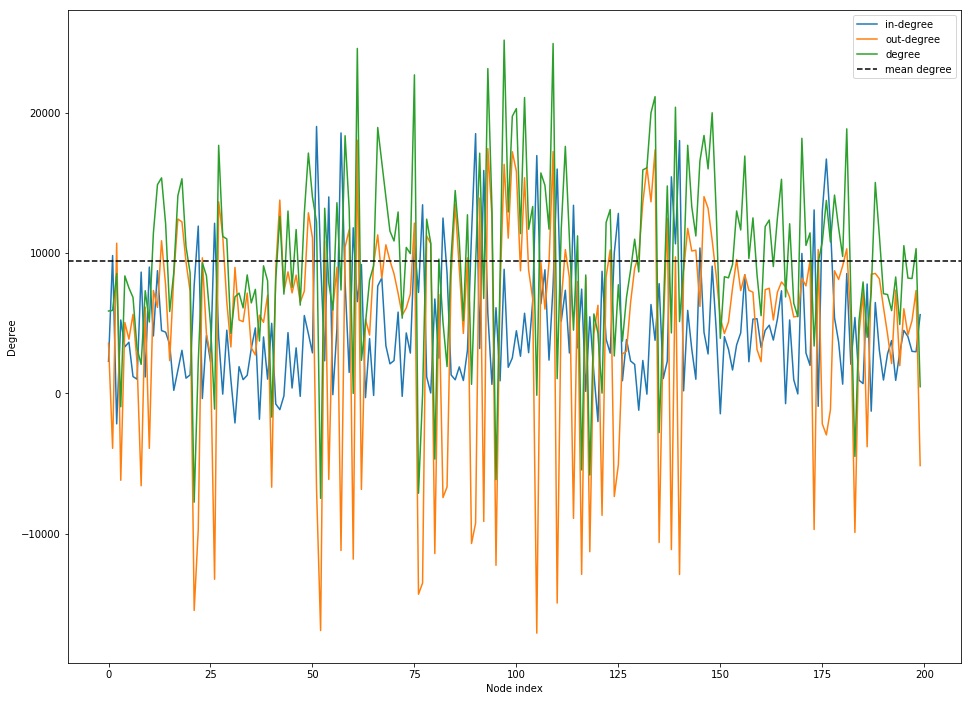

In [29]:
plt.figure(figsize=(16, 12))
plt.plot(np.arange(N), indegree, label="in-degree")
plt.plot(np.arange(N), outdegree, label="out-degree")
plt.plot(np.arange(N), degree, label="degree")
plt.axhline(np.mean(degree), color="k", linestyle="dashed", label="mean degree")
plt.xlabel("Node index")
plt.ylabel("Degree")
plt.legend(loc="best")

To compare the reservoir connectivity model with an instance of the Watts-Strogatz model we need to estimate the average number of incoming and outgoing connections.

In [41]:
indegree = [val for (node, val) in G.in_degree()]
outdegree = [val for (node, val) in G.out_degree()]
mu_in = np.mean(indegree)
sigma_in = np.std(indegree)
mu_out = np.mean(outdegree)
sigma_out = np.std(outdegree)

In [50]:
from IPython.display import display, Math
display(Math(r'Mean\ in-degree: {:.2f}\pm{:.2f}'.format(mu_in, sigma_in)))
display(Math(r'Mean\ out-degree: {:.2f}\pm{:.2f}'.format(mu_out, sigma_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

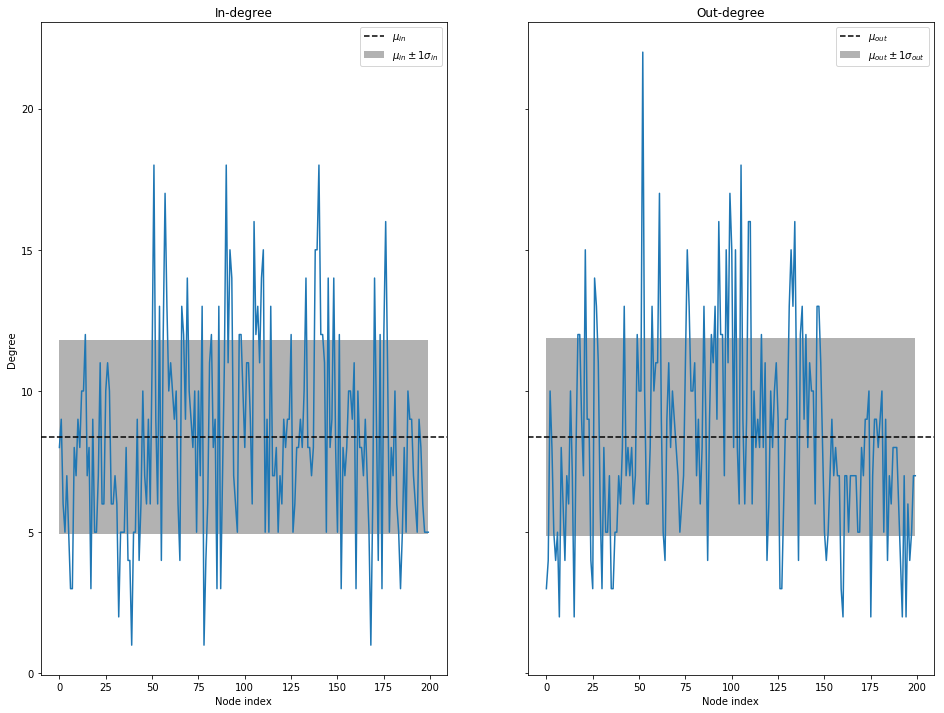

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 12))
ax1.plot(np.arange(N), indegree)
ax2.plot(np.arange(N), outdegree)
ax1.axhline(mu_in, color="k", linestyle="dashed", label="$\mu_{in}$")
ax2.axhline(mu_out, color="k", linestyle="dashed", label="$\mu_{out}$")
ax1.fill_between(np.arange(N), mu_in+sigma_in, mu_in-sigma_in, facecolor="gray", alpha=0.6, label="$\mu_{in}\pm 1\sigma_{in}$")
ax2.fill_between(np.arange(N), mu_in+sigma_out, mu_in-sigma_out, facecolor="gray", alpha=0.6, label="$\mu_{out}\pm 1\sigma_{out}$")
ax1.set_xlabel("Node index")
ax2.set_xlabel("Node index")
ax1.set_ylabel("Degree")
ax1.set_title("In-degree")
ax2.set_title("Out-degree")
ax1.legend(loc="best")
ax2.legend(loc="best")

## Comparison with Watts-Strogatz model

The [Watts-Strogatz model](https://en.wikipedia.org/wiki/Watts%E2%80%93Strogatz_model) is a random graph generator that produces graphs with small-world topology. These are graphs with a high clustering coefficient and a short average path length.

We use the following implementation of the model from [Song and Wang](http://www.nervouscomputer.com/hfs/super-simple-watts-strogatz/), which is a reformulation of the classical model with a distance matrix.

In [90]:
from scipy.linalg import circulant

def _distance_matrix(L):
    Dmax = L//2
 
    D  = list(range(Dmax+1))
    D += D[-2+(L%2):0:-1]
 
    return circulant(D)/Dmax
 
def _pd(d, p0, beta):
    return beta*p0 + (d <= p0)*(1-beta)
 
def watts_strogatz(L, p0, beta, directed=False, rngseed=1):
    """
    Watts-Strogatz model of a small-world network
 
    This generates the full adjacency matrix, which is not a good way to store
    things if the network is sparse.
 
    Parameters
    ----------
    L        : int
               Number of nodes.
 
    p0       : float
               Edge density. If K is the average degree then p0 = K/(L-1).
               For directed networks "degree" means out- or in-degree.
 
    beta     : float
               "Rewiring probability."
 
    directed : bool
               Whether the network is directed or undirected.
 
    rngseed  : int
               Seed for the random number generator.
 
    Returns
    -------
    A        : (L, L) array
               Adjacency matrix of a WS (potentially) small-world network.
 
    """
    rng = np.random.RandomState(rngseed)
 
    d = _distance_matrix(L)
    p = _pd(d, p0, beta)
 
    if directed:
        A = 1*(rng.random_sample(p.shape) < p)
        np.fill_diagonal(A, 0)
    else:
        upper = np.triu_indices(L, 1)
 
        A          = np.zeros_like(p, dtype=int)
        A[upper]   = 1*(rng.rand(len(upper[0])) < p[upper])
        A.T[upper] = A[upper]
 
    return A

In [104]:
A_ws = watts_strogatz(N, mu_in/(N-1), 0.1, directed=True)

In [105]:
G_ws = nx.from_numpy_matrix(A_ws, create_using=nx.DiGraph)

In [106]:
pos = nx.circular_layout(G_ws)

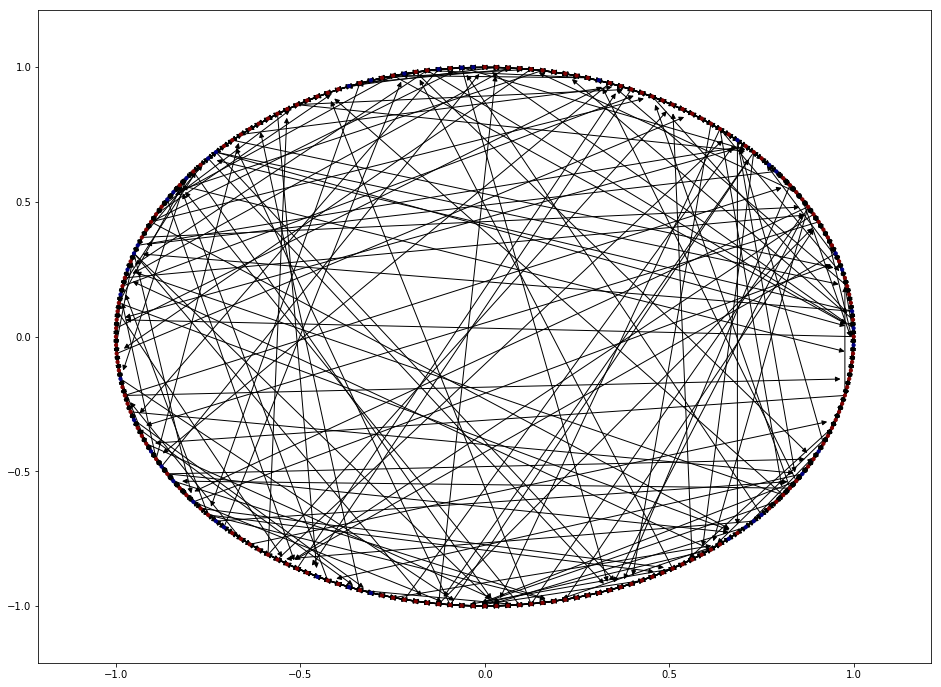

In [107]:
plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(G_ws, pos, node_size=10, node_color=types, cmap=plt.get_cmap('jet'), vmin=-1.0, wma=1.0)
nx.draw_networkx_edges(G_ws, pos)
plt.show()

In [110]:
indegree = [val for (node, val) in G_ws.in_degree()]
outdegree = [val for (node, val) in G_ws.out_degree()]
degree = [val for (node, val) in G_ws.degree()]
mu_in = np.mean(indegree)
sigma_in = np.std(indegree)
mu_out = np.mean(outdegree)
sigma_out = np.std(outdegree)

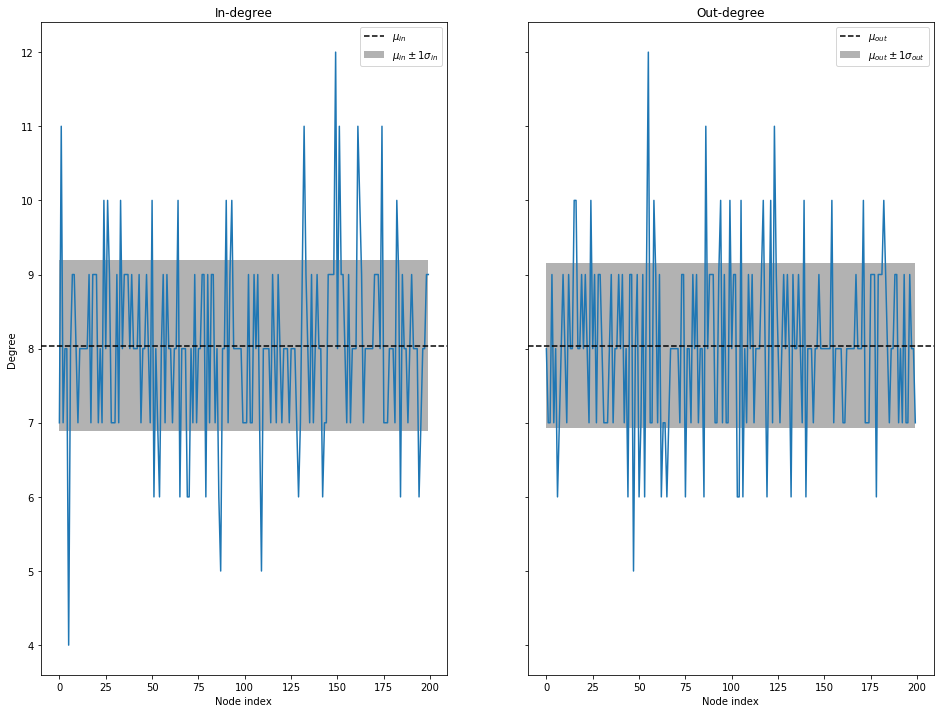

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 12))
ax1.plot(np.arange(N), indegree)
ax2.plot(np.arange(N), outdegree)
ax1.axhline(mu_in, color="k", linestyle="dashed", label="$\mu_{in}$")
ax2.axhline(mu_out, color="k", linestyle="dashed", label="$\mu_{out}$")
ax1.fill_between(np.arange(N), mu_in+sigma_in, mu_in-sigma_in, facecolor="gray", alpha=0.6, label="$\mu_{in}\pm 1\sigma_{in}$")
ax2.fill_between(np.arange(N), mu_in+sigma_out, mu_in-sigma_out, facecolor="gray", alpha=0.6, label="$\mu_{out}\pm 1\sigma_{out}$")
ax1.set_xlabel("Node index")
ax2.set_xlabel("Node index")
ax1.set_ylabel("Degree")
ax1.set_title("In-degree")
ax2.set_title("Out-degree")
ax1.legend(loc="best")
ax2.legend(loc="best")

# Navigable small world graph

In [112]:
G_sm = nx.navigable_small_world_graph(5, 2, 3, 2, dim=3)

In [113]:
pos = nx.circular_layout(G_sm)

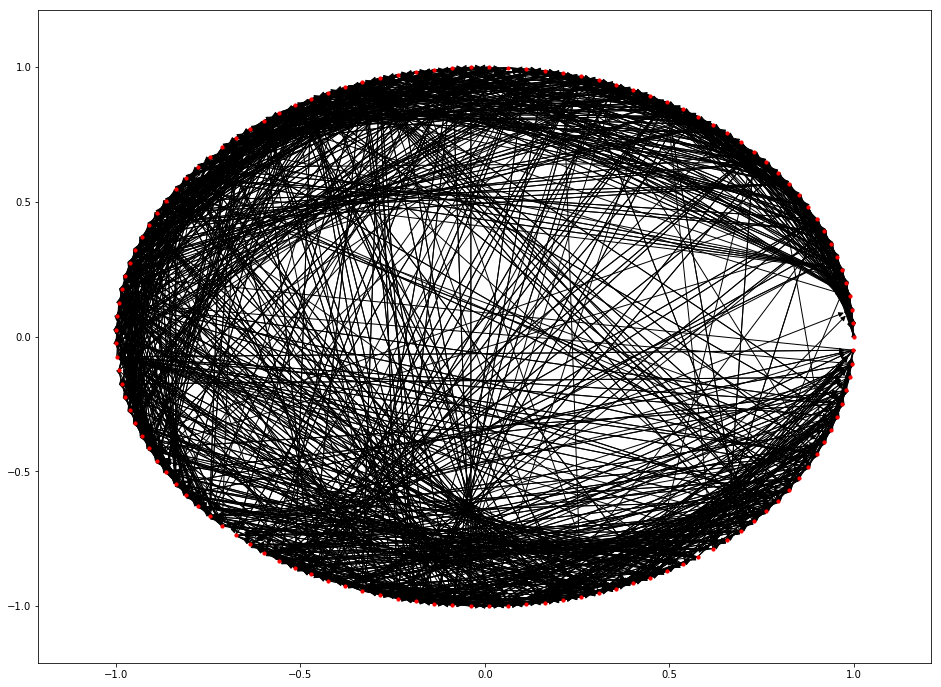

In [115]:
plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(G_sm, pos, node_size=10)
nx.draw_networkx_edges(G_sm, pos)
plt.show()

In [116]:
indegree = [val for (node, val) in G_sm.in_degree()]
outdegree = [val for (node, val) in G_sm.out_degree()]
degree = [val for (node, val) in G_sm.degree()]
mu_in = np.mean(indegree)
sigma_in = np.std(indegree)
mu_out = np.mean(outdegree)
sigma_out = np.std(outdegree)

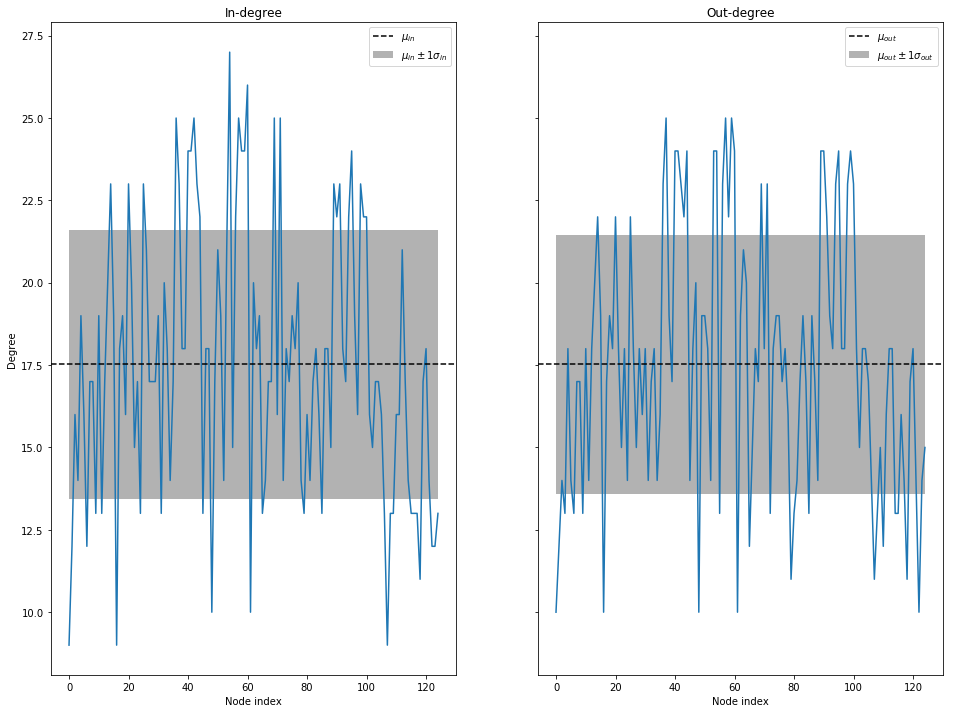

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 12))
ax1.plot(np.arange(125), indegree)
ax2.plot(np.arange(125), outdegree)
ax1.axhline(mu_in, color="k", linestyle="dashed", label="$\mu_{in}$")
ax2.axhline(mu_out, color="k", linestyle="dashed", label="$\mu_{out}$")
ax1.fill_between(np.arange(125), mu_in+sigma_in, mu_in-sigma_in, facecolor="gray", alpha=0.6, label="$\mu_{in}\pm 1\sigma_{in}$")
ax2.fill_between(np.arange(125), mu_in+sigma_out, mu_in-sigma_out, facecolor="gray", alpha=0.6, label="$\mu_{out}\pm 1\sigma_{out}$")
ax1.set_xlabel("Node index")
ax2.set_xlabel("Node index")
ax1.set_ylabel("Degree")
ax1.set_title("In-degree")
ax2.set_title("Out-degree")
ax1.legend(loc="best")
ax2.legend(loc="best")